In [ ]:
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install datasets
!pip install -q monai

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-421wpdwe
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-421wpdwe
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=92aea4710f22d118e67866771f2dd9edad40f6cd390003168240adc2bf508a34
  Stored in directory: /tmp/pip-ephem-wheel-cache-1m5yta23/wheels/29/82/ff/04e2be9805a1cb48bec0b85b5a6da6b63f647645750a0e42d4
Successfully built segment_anything
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 528.7/528.7 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB

In [ ]:
!pip install opencv-python


In [ ]:
!pip install -q patchify --no-deps

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random
from glob import glob
from PIL import Image
import torch
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from datasets import Dataset as HFDataset
from transformers import SamProcessor, SamModel, SamConfig
from tqdm import tqdm
from statistics import mean
import monai

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!mkdir -p /content/oilspill_dataset


In [ ]:
!wget -q https://zenodo.org/records/10555314/files/dataset.zip -O /content/oilspill_dataset/dataset.zip


In [ ]:
!unzip -q /content/oilspill_dataset/dataset.zip -d /content/oilspill_dataset/


In [ ]:
def load_oil_spill_data(base_path='/content/oilspill_dataset', target_size=(256, 256)):
    """Load oil spill images and masks from the dataset"""

    # Get all image and mask paths
    train_img_paths = sorted(glob(f"{base_path}/train/images/*.jpg"))
    train_mask_paths = sorted(glob(f"{base_path}/train/masks/*.png"))

    print(f"Found {len(train_img_paths)} training images")
    print(f"Found {len(train_mask_paths)} training masks")

    # Load images and masks
    images = []
    masks = []

    for img_path, mask_path in tqdm(zip(train_img_paths, train_mask_paths),
                                     total=len(train_img_paths),
                                     desc="Loading data"):
        # Load image (convert to grayscale or keep RGB based on your need)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, target_size, interpolation=cv2.INTER_LINEAR)

        # Load mask (convert to binary)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)
        mask = (mask > 0).astype(np.uint8)  # Binarize mask

        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)

# Load the data
images, masks = load_oil_spill_data()
print(f"Images shape: {images.shape}")
print(f"Masks shape: {masks.shape}")
def load_oil_spill_data(base_path='/content/oilspill_dataset', target_size=(256, 256)):
    """Load oil spill images and masks from the dataset"""

    # Get all image and mask paths
    train_img_paths = sorted(glob(f"{base_path}/train/images/*.jpg"))
    train_mask_paths = sorted(glob(f"{base_path}/train/masks/*.png"))

    print(f"Found {len(train_img_paths)} training images")
    print(f"Found {len(train_mask_paths)} training masks")

    # Load images and masks
    images = []
    masks = []

    for img_path, mask_path in tqdm(zip(train_img_paths, train_mask_paths),
                                     total=len(train_img_paths),
                                     desc="Loading data"):
        # Load image (convert to grayscale or keep RGB based on your need)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, target_size, interpolation=cv2.INTER_LINEAR)

        # Load mask (convert to binary)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)
        mask = (mask > 0).astype(np.uint8)  # Binarize mask

        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)

# Load the data
images, masks = load_oil_spill_data()
print(f"Images shape: {images.shape}")
print(f"Masks shape: {masks.shape}")


Found 811 training images
Found 811 training masks


Loading data: 100%|██████████| 811/811 [00:40<00:00, 19.94it/s]


Images shape: (811, 256, 256, 3)
Masks shape: (811, 256, 256)
Found 811 training images
Found 811 training masks


Loading data: 100%|██████████| 811/811 [00:40<00:00, 19.93it/s]


Images shape: (811, 256, 256, 3)
Masks shape: (811, 256, 256)


In [ ]:
valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]
filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]

print(f"Filtered images shape: {filtered_images.shape}")
print(f"Filtered masks shape: {filtered_masks.shape}")

Filtered images shape: (811, 256, 256, 3)
Filtered masks shape: (811, 256, 256)


In [ ]:
dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
}

dataset = HFDataset.from_dict(dataset_dict)
print(f"Dataset created with {len(dataset)} samples")

Dataset created with 811 samples


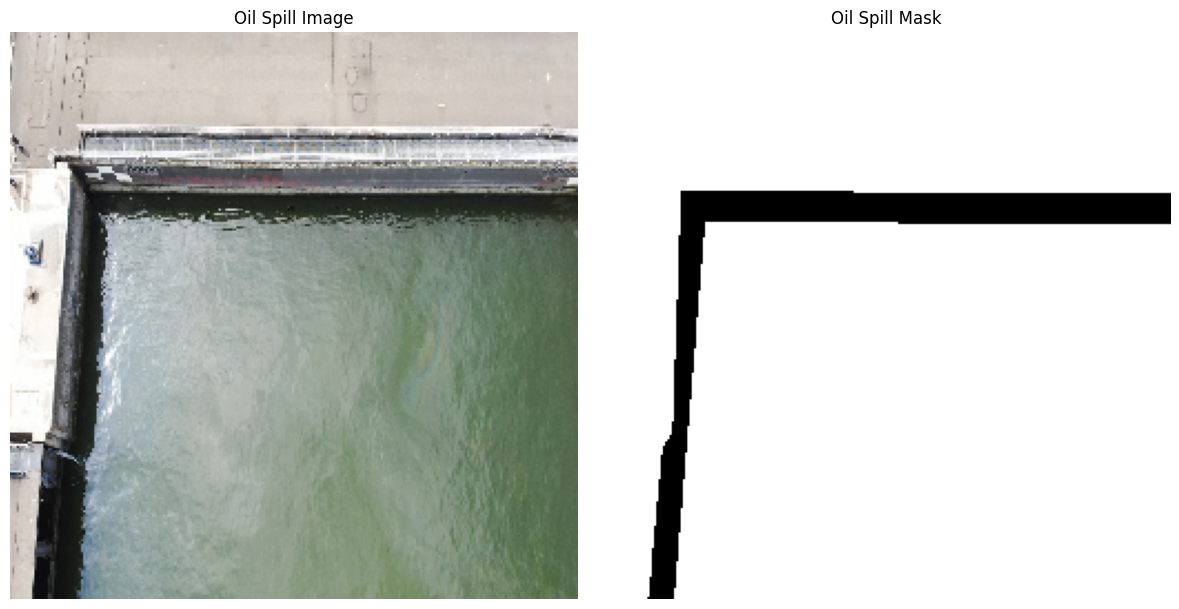

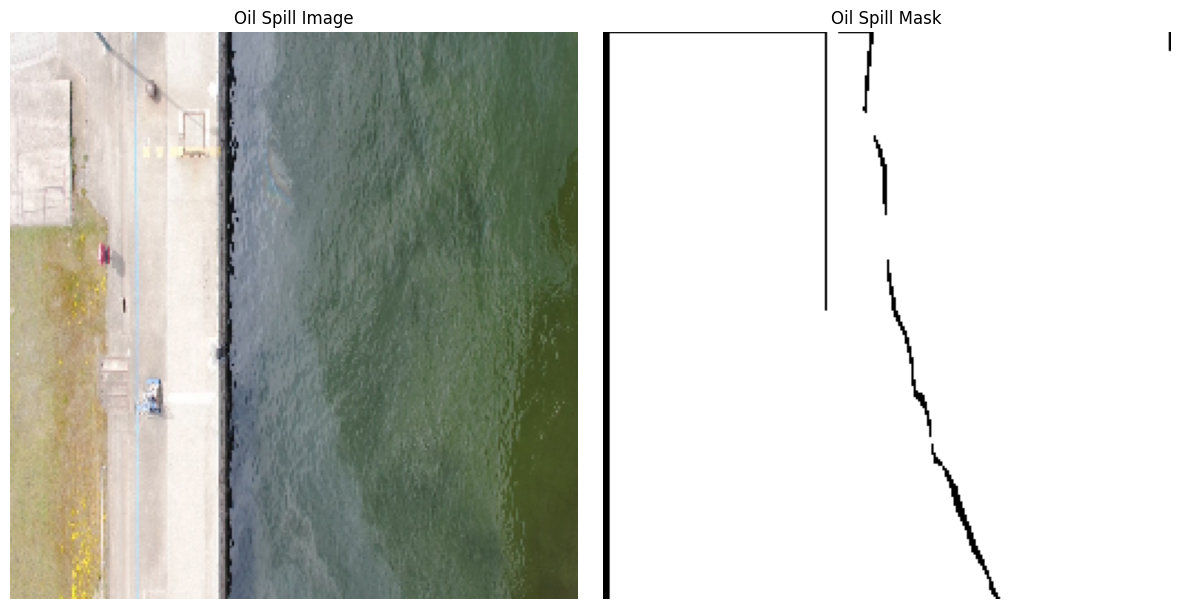

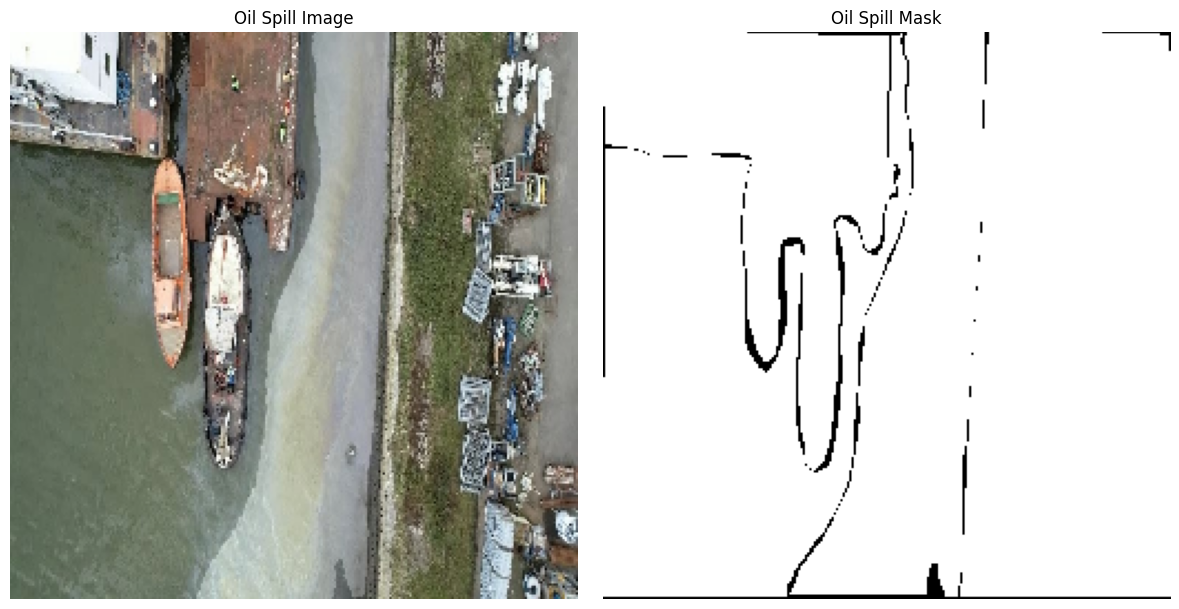

In [ ]:
def visualize_sample(dataset, idx=None):
    """Visualize a random or specific sample from dataset"""
    if idx is None:
        idx = random.randint(0, len(dataset)-1)

    example_image = dataset[idx]["image"]
    example_mask = dataset[idx]["label"]

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(np.array(example_image))
    axes[0].set_title("Oil Spill Image")
    axes[0].axis('off')

    axes[1].imshow(example_mask, cmap='gray')
    axes[1].set_title("Oil Spill Mask")
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize a few samples
for _ in range(3):
    visualize_sample(dataset)

In [ ]:
def get_bounding_box(ground_truth_map):
    """Extract bounding box from binary mask with random perturbation"""
    y_indices, x_indices = np.where(ground_truth_map > 0)

    if len(x_indices) == 0 or len(y_indices) == 0:
        # Return a default box if mask is empty
        return [0, 0, ground_truth_map.shape[1], ground_truth_map.shape[0]]

    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)

    # Add perturbation to bounding box coordinates
    H, W = ground_truth_map.shape
    x_min = max(0, x_min - np.random.randint(0, 20))
    x_max = min(W, x_max + np.random.randint(0, 20))
    y_min = max(0, y_min - np.random.randint(0, 20))
    y_max = min(H, y_max + np.random.randint(0, 20))

    bbox = [x_min, y_min, x_max, y_max]
    return bbox


In [ ]:
class SAMDataset(Dataset):
    """Custom dataset for SAM training"""

    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item["image"]
        ground_truth_mask = np.array(item["label"])

        # Get bounding box prompt
        prompt = get_bounding_box(ground_truth_mask)

        # Prepare image and prompt for the model
        inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

        # Remove batch dimension
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}

        # Add ground truth segmentation
        inputs["ground_truth_mask"] = ground_truth_mask

        return inputs

In [ ]:
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
train_dataset = SAMDataset(dataset=dataset, processor=processor)

# Create DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, drop_last=False)

print("DataLoader created successfully!")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

DataLoader created successfully!


In [ ]:
model = SamModel.from_pretrained("facebook/sam-vit-base")

# Freeze vision encoder and prompt encoder
for name, param in model.named_parameters():
    if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
        param.requires_grad_(False)

print("Model loaded and configured!")


model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

Model loaded and configured!


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

model.to(device)

# Optimizer and loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

Using device: cuda


In [ ]:
def train_model(model, dataloader, optimizer, seg_loss, num_epochs=10, save_path='/content/drive/MyDrive/models/oil_spill_sam.pth'):
    """Train the SAM model"""

    model.train()

    for epoch in range(num_epochs):
        epoch_losses = []

        for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            # Forward pass
            outputs = model(
                pixel_values=batch["pixel_values"].to(device),
                input_boxes=batch["input_boxes"].to(device),
                multimask_output=False
            )

            # Compute loss
            predicted_masks = outputs.pred_masks.squeeze(1)
            ground_truth_masks = batch["ground_truth_mask"].float().to(device)
            loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())

        mean_loss = mean(epoch_losses)
        print(f'Epoch {epoch+1}/{num_epochs} - Mean loss: {mean_loss:.4f}')

        # Save checkpoint every epoch
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        torch.save(model.state_dict(), save_path)
        print(f"Model saved to {save_path}")

    return model

# Train the model
trained_model = train_model(model, train_dataloader, optimizer, seg_loss, num_epochs=10)


Epoch 1/10: 100%|██████████| 203/203 [06:18<00:00,  1.86s/it]


Epoch 1/10 - Mean loss: 0.1514
Model saved to /content/drive/MyDrive/models/oil_spill_sam.pth



Epoch 2/10: 100%|██████████| 203/203 [06:20<00:00,  1.88s/it]


Epoch 2/10 - Mean loss: 0.1249
Model saved to /content/drive/MyDrive/models/oil_spill_sam.pth



Epoch 3/10: 100%|██████████| 203/203 [06:21<00:00,  1.88s/it]


Epoch 3/10 - Mean loss: 0.1164
Model saved to /content/drive/MyDrive/models/oil_spill_sam.pth



Epoch 4/10: 100%|██████████| 203/203 [06:21<00:00,  1.88s/it]


Epoch 4/10 - Mean loss: 0.1109
Model saved to /content/drive/MyDrive/models/oil_spill_sam.pth



Epoch 5/10: 100%|██████████| 203/203 [06:21<00:00,  1.88s/it]


Epoch 5/10 - Mean loss: 0.1056
Model saved to /content/drive/MyDrive/models/oil_spill_sam.pth



Epoch 6/10: 100%|██████████| 203/203 [06:21<00:00,  1.88s/it]


Epoch 6/10 - Mean loss: 0.1018
Model saved to /content/drive/MyDrive/models/oil_spill_sam.pth



Epoch 7/10: 100%|██████████| 203/203 [06:21<00:00,  1.88s/it]


Epoch 7/10 - Mean loss: 0.0995
Model saved to /content/drive/MyDrive/models/oil_spill_sam.pth



Epoch 8/10: 100%|██████████| 203/203 [06:21<00:00,  1.88s/it]


Epoch 8/10 - Mean loss: 0.0963
Model saved to /content/drive/MyDrive/models/oil_spill_sam.pth



Epoch 9/10: 100%|██████████| 203/203 [06:21<00:00,  1.88s/it]


Epoch 9/10 - Mean loss: 0.0937
Model saved to /content/drive/MyDrive/models/oil_spill_sam.pth



Epoch 10/10: 100%|██████████| 203/203 [06:15<00:00,  1.85s/it]


Epoch 10/10 - Mean loss: 0.0928
Model saved to /content/drive/MyDrive/models/oil_spill_sam.pth


In [ ]:
# Save the trained model to Google Drive
save_path = '/content/drive/MyDrive/ColabNotebooks/models/SAM/oil_spill_sam_final.pth'

# Create directory if it doesn't exist
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Save the model
torch.save(trained_model.state_dict(), save_path)
print(f"Model saved successfully to {save_path}")

Model saved successfully to /content/drive/MyDrive/ColabNotebooks/models/SAM/oil_spill_sam_final.pth


Loaded 254 test images


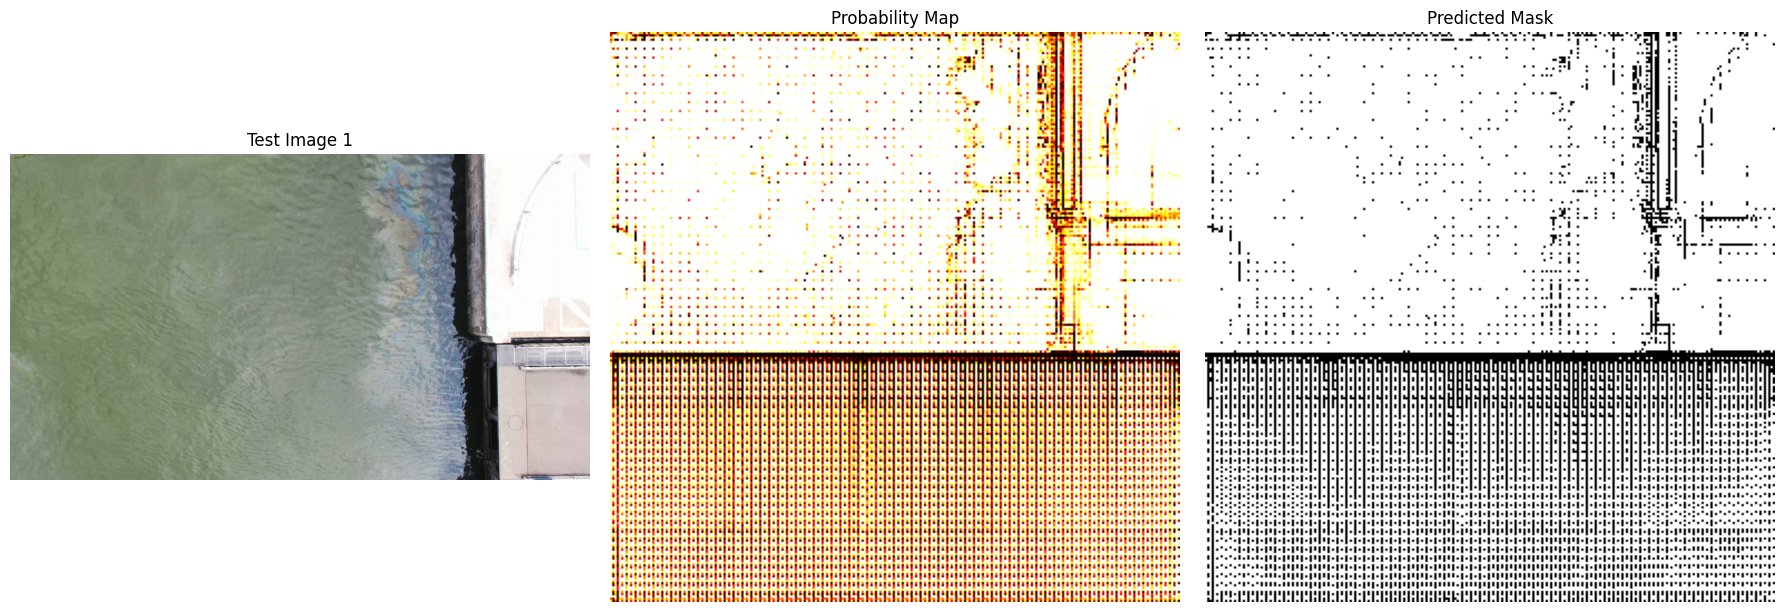

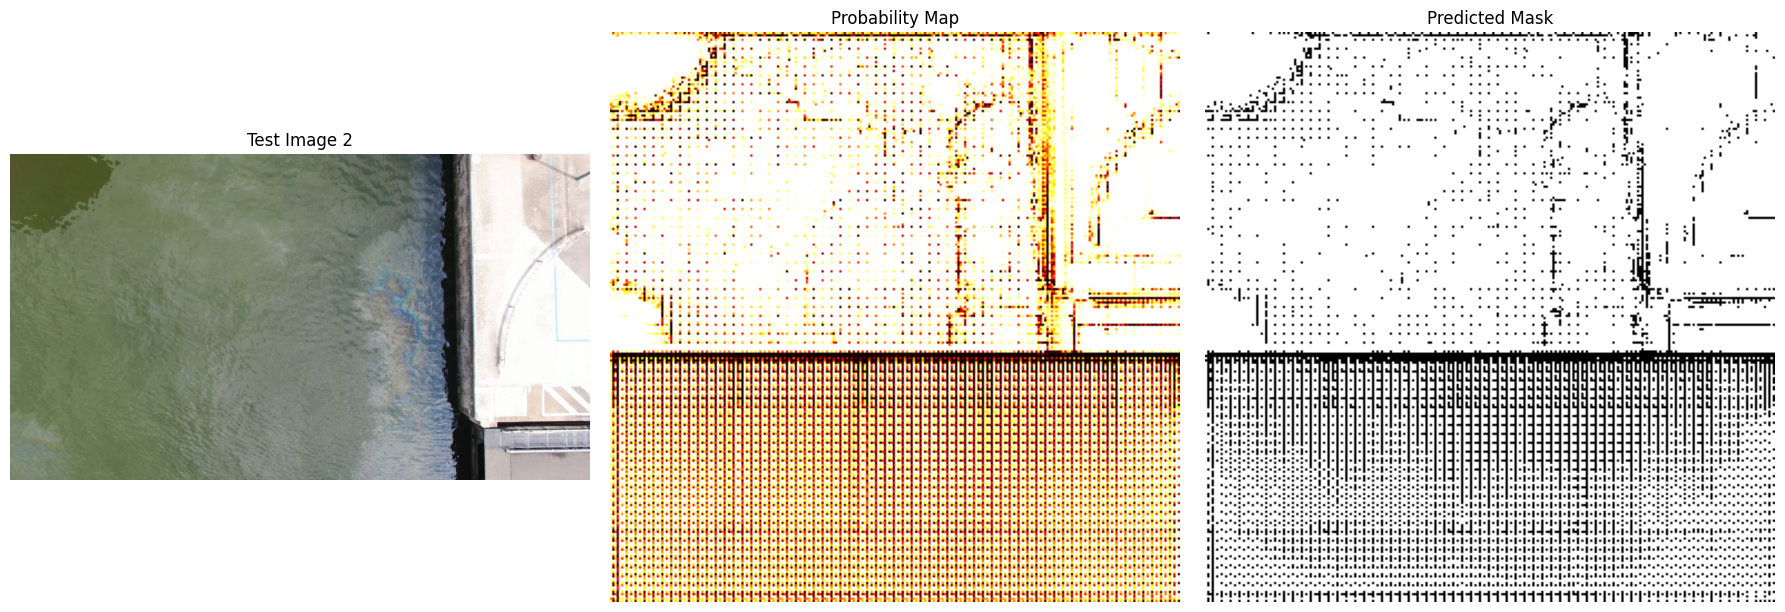

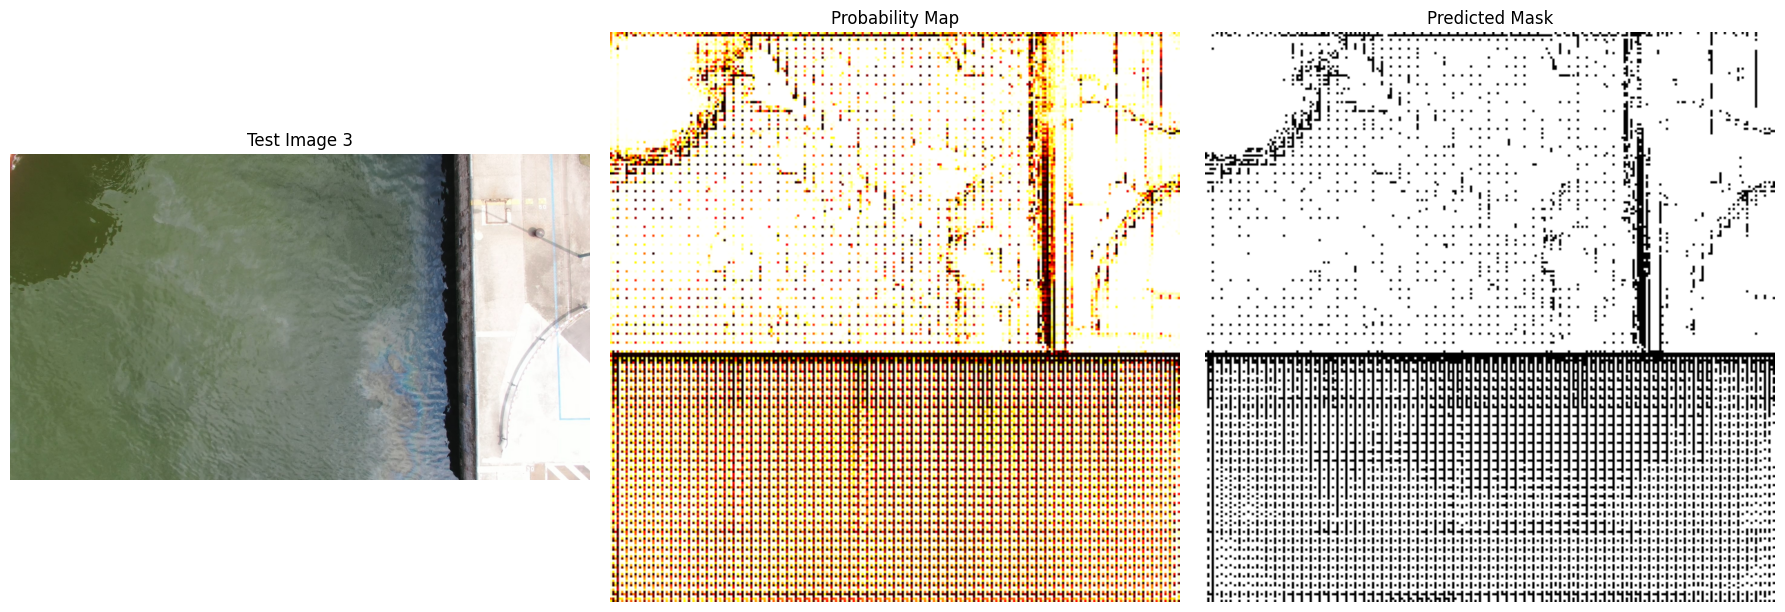

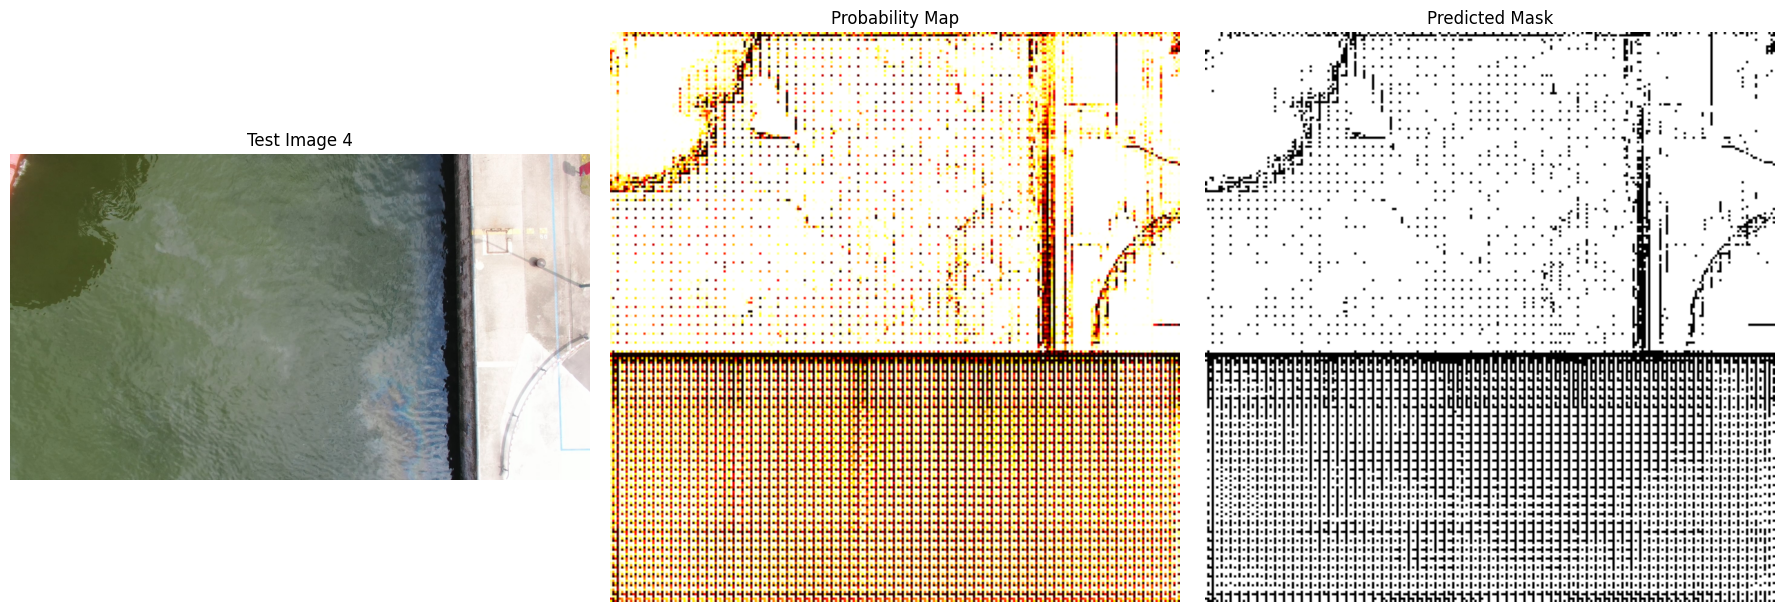

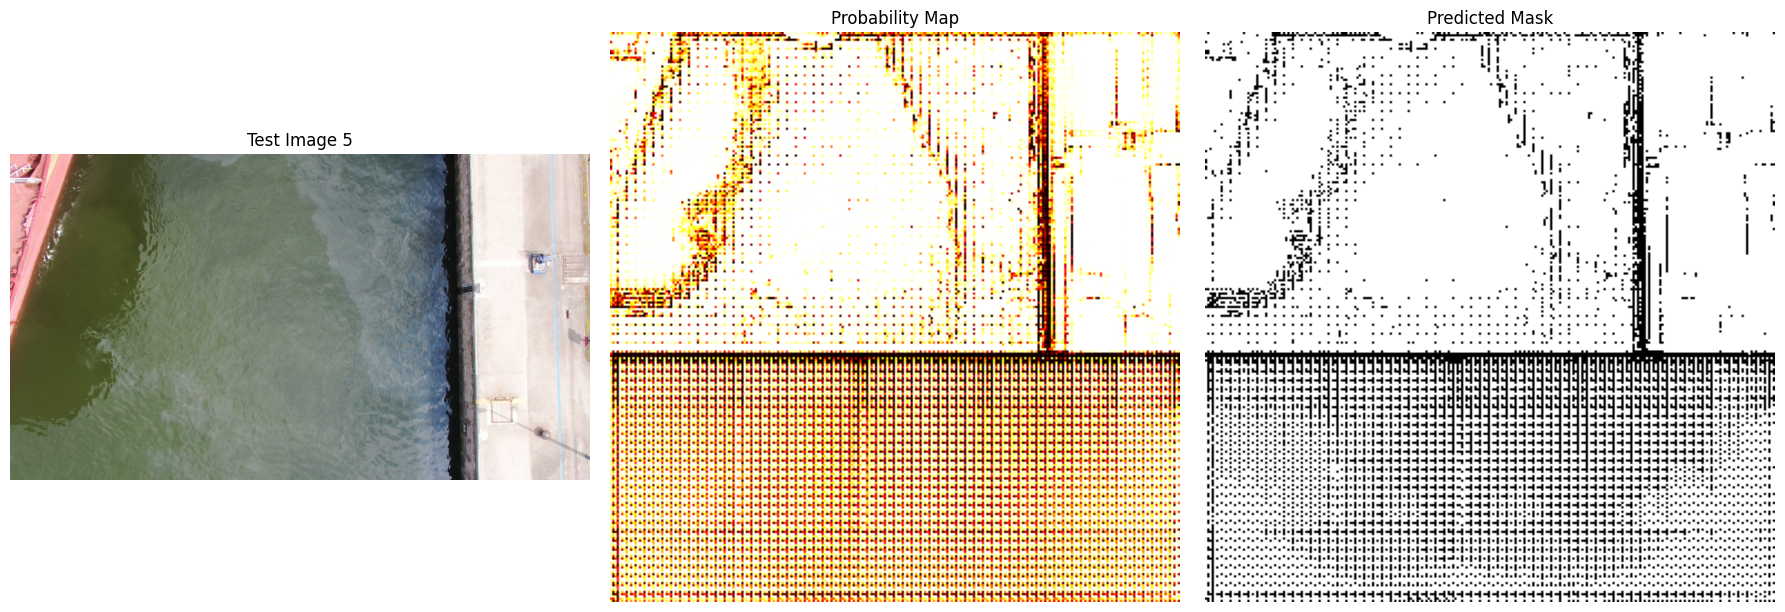

Oil spill detection pipeline complete!


In [ ]:

def load_test_data(base_path='/content/oilspill_dataset'):
    """Load test images"""
    test_img_paths = sorted(glob(f"{base_path}/test/images/*.jpg"))

    test_images = []
    for img_path in test_img_paths:
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        test_images.append(img)

    return test_images, test_img_paths

def create_grid_points(array_size, grid_size=10):
    """Create a grid of points for prompting"""
    x = np.linspace(0, array_size-1, grid_size)
    y = np.linspace(0, array_size-1, grid_size)
    xv, yv = np.meshgrid(x, y)

    xv_list = xv.tolist()
    yv_list = yv.tolist()

    input_points = [[[int(x), int(y)] for x, y in zip(x_row, y_row)]
                    for x_row, y_row in zip(xv_list, yv_list)]

    input_points = torch.tensor(input_points).view(1, 1, grid_size*grid_size, 2)
    return input_points

def predict_oil_spill(model, processor, image, device, use_points=True):
    """Predict oil spill segmentation on a single image"""

    pil_image = Image.fromarray(image)

    if use_points:
        # Use grid of points as prompt
        h, w = image.shape[:2]
        grid_size = min(h, w) // 25  # Adaptive grid size
        input_points = create_grid_points(min(h, w), grid_size)
        inputs = processor(pil_image, input_points=input_points, return_tensors="pt")
    else:
        # No prompt
        inputs = processor(pil_image, return_tensors="pt")

    inputs = {k: v.to(device) for k, v in inputs.items()}

    model.eval()
    with torch.no_grad():
        outputs = model(**inputs, multimask_output=False)

    # Apply sigmoid and threshold
    seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
    seg_prob = seg_prob.cpu().numpy().squeeze()
    seg_mask = (seg_prob > 0.5).astype(np.uint8)

    return seg_mask, seg_prob

# Load test data
test_images, test_paths = load_test_data()
print(f"Loaded {len(test_images)} test images")

# Predict on a few test images
for i in range(min(5, len(test_images))):
    test_image = test_images[i]
    seg_mask, seg_prob = predict_oil_spill(trained_model, processor, test_image, device)

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    axes[0].imshow(test_image)
    axes[0].set_title(f"Test Image {i+1}")
    axes[0].axis('off')

    axes[1].imshow(seg_prob, cmap='hot')
    axes[1].set_title("Probability Map")
    axes[1].axis('off')

    axes[2].imshow(seg_mask, cmap='gray')
    axes[2].set_title("Predicted Mask")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

print("Oil spill detection pipeline complete!")